# IFT6135-A2022
# Assignment 3: Diffusion Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `ddpm_solution.py` and submit it on Gradescope.

Only edit the functions specified in the PDF (and wherever marked – `# WRITE CODE HERE`). Do not change definitions or edit the rest of the template, else the autograder will not work.

**Make sure you request a GPU runtime!**

# Diffusion Basics

Diffusion models are a new and recent class of generative models that rely on a forward diffusion process and a backward denoising process. The forward diffusion process adds a little bit of noise at each step, thus making the input image progressively noisier. On the other hand, the aim of the backward process is to denoise at each step, and is supposed to reverse the effect of the forward process. In this setup, only the backward process is parameterized by a learnable model while the forward process converges to something known, like $\mathcal{N}(0, I)$. If the learning is done correctly and the backward process works well enough, it would ideally be able to progressively remove noise from complete noise and lead to a sample from the data distribution.

Now, lets try to formalize this. Suppose our data samples come from the distribution $q(x_0)$. The forward distribution can be parameterized as 

\begin{align*}
q(x_t | x_{t-1}) = \mathcal{N}(\sqrt{1-\beta_t} x_{t-1}, \beta_t I)
\end{align*}

where if we consider a finite number of timesteps T, then

\begin{align*}
q(x_{1:T} | x_0) = \prod_{t=1}^T q(x_t | x_{t-1})
\end{align*}

where $\beta_t$ are the hyperparameters that govern how quickly structure is destroyed in the forward process. One can see this as progressively adding more noise to the input data. One benefit of considering a gaussian distribution above is that it leads to a very nice property that the distribution $q(x_t | x_0)$ becomes known and tractable, so one is able to directly generate a sample from any point in the forward trajectory. In particular, with a bit of algebra, one can obtain

\begin{align*}
q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
\end{align*}

where $\bar{\alpha}_t = \prod_{i=1}^t \alpha_t$ and $\alpha_t = 1 - \beta_t$. And ideally we want to set $\beta_t$'s such that $q(x_T | x_0) \approx \mathcal{N}(0, I)$.

So far, we have obtained the forward structure-destroying diffusion process as well as how to sample directly from any point in the forward process conditioned on the initial conditions. Now, we want to learn a reverse process that takes us back from a noisy sample to something that has less noise. We do this by parameterizing this distribution with a Neural Network like

\begin{align*}
  p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t)
\end{align*}

where we consider $p(x_T)$ as just $\mathcal{N}(0, I)$ since at the end of the forward diffusion we are approximating that. Further, we also assume that each conditional above is parameterized as a gaussian distribution, that is

\begin{align*}
  p_\theta(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta(x_t, t), \tilde{\beta}_t)
\end{align*}

where $\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$ which is because after doing some algebra, we can find that

\begin{align*}
  q(x_{t-1} | x_t, x_0) = \mathcal{N}(\tilde{\mu}_t, \tilde{\beta}_t)
\end{align*}

where $\tilde{\mu}_t = \frac{\sqrt{\alpha_t} ( 1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}x_0$. 

This particular parameterization of $q(x_{t-1} | x_t, x_0)$ follows through by considering the Bayes rule combined with some algebra. Since the backward learned process is aimed to approximate the true backward process $q(x_{t-1} | x_t, x_0)$, it boils down to matching the means $\tilde{\mu}_t$ with $\mu_\theta(x_t)$ as the variances are kept the same by design. A little more algebraic manipulation and reparameterization tricks lead us to

\begin{align*}
  \tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t\right)
\end{align*}

To match this, we need $\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t\right)
$

Given this formulation for $\mu_\theta$, we can use reparameterization to get $x_{t-1}$ from $x_t$ as

\begin{align*}
  x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t\right) + \tilde{\beta}_t \epsilon
\end{align*}

Thus, instead of parameterizing $\mu_\theta$ using a Neural Network, one can parameterize $\epsilon_t$ using the network so that we can do the backward diffusion as

\begin{align*}
  x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)\right) + \tilde{\beta}_t \epsilon
\end{align*}

In short, thus, we get a forward diffusion process parameterized as $q(x_t | x_{t-1} = \mathcal{N}(\sqrt{1 - \beta_t} x_{t-1}, \beta_t I)$ where one can sample $q(x_t | x_0)$ in one-shot in closed form without having to go through $t = 1, ..., t-1$. On the other hand, the backward process parameterizes the noise at time-step $t$, that is $\epsilon_\theta(x_t, t)$ which can be used to run the backward process as $p(x_{t-1} | x_t) = \mathcal{N}(\frac{1}{\sqrt{\alpha}_t} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t} }\epsilon_\theta(x_t, t)\right), \tilde{\beta}_t I)$.

And learning of this model leads to a simple objective function, which can be defined as 
\begin{align*}
\mathbb{E}_{t\sim \mathcal{U}(1,T), x_0, \epsilon_t} \left[|| \epsilon_t - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t, t) ||^2\right]
\end{align*}

For our settings, instead of the $L_2$ loss, we will use the huber loss, which is $L_1$ loss but near the origin, acts as an $L_2$ loss. For details, refer [here](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). For more details about diffusion models, please refer to the [DDPM paper](https://arxiv.org/abs/2006.11239) and the related [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

In [1]:
pip install -q -U einops

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
from tqdm.auto import tqdm

from inspect import isfunction
from functools import partial
import math
from einops import rearrange

import torch
import torch.nn.functional as F
from torch import nn
from torch import einsum
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.utils import make_grid, save_image
from torchvision import transforms

import matplotlib.pyplot as plt
from pathlib import Path


def fix_experiment_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

fix_experiment_seed()

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Helper Functions
def show_image(image, nrow=8):
  # Input: image
  # Displays the image using matplotlib
  grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

## Set up the hyperparameters
- Train Batch Size
- Learning Rate
- Diffusion timesteps: $T$
- Starting variance: $\beta_1$
- Ending variance: $\beta_T$

In [4]:
# Training Hyperparameters
train_batch_size = 64   # Batch Size
lr = 1e-4         # Learning Rate

# Hyperparameters taken from Ho et. al for noise scheduling
T = 1000            # Diffusion Timesteps
beta_start = 0.0001 # Starting variance
beta_end = 0.02     # Ending variance

## Set up dataset, we are using SVHN dataset for this assignment.


In [5]:
# Define Dataset Statistics
image_size = 32
input_channels = 3
data_root = './data'

In [6]:
def get_dataloaders(data_root, batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
    transform = transforms.Compose((
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize))
    
    train = datasets.SVHN(data_root, split='train', download=True, transform=transform)
    test = datasets.SVHN(data_root, split='test', download=True, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    return train_dataloader, test_dataloader

## Visualize the Data

Lets visualize what our data actually looks like! We are using the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/) which comprises of images of house numbers seen from the streets.

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

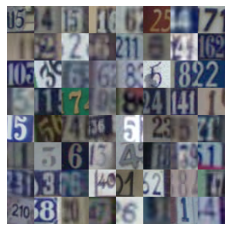

In [7]:
# Visualize the Dataset
def visualize():
  train_dataloader, _ = get_dataloaders(data_root=data_root, batch_size=train_batch_size)
  imgs, labels = next(iter(train_dataloader))

  save_image((imgs + 1.) * 0.5, './results/orig.png')
  show_image((imgs + 1.) * 0.5)

if __name__ == '__main__':
  visualize()

## Helper Functions / Building Blocks

Here we provide some helper functions and building blocks that will allow us to create the U-Net network that parameterizes the backward noise prediction network in diffusion models.

In [8]:
def exists(x):
  return x is not None

def default(val, d):
  if exists(val):
    return val
  return d() if isfunction(d) else d

class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, *args, **kwargs):
    return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
  return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
  return nn.Conv2d(dim, dim, 4, 2, 1)

class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

class Block(nn.Module):
  def __init__(self, dim, dim_out, groups = 8):
    super().__init__()
    self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
    self.norm = nn.GroupNorm(groups, dim_out)
    self.act = nn.SiLU()

  def forward(self, x, scale_shift = None):
    x = self.proj(x)
    x = self.norm(x)

    if exists(scale_shift):
      scale, shift = scale_shift
      x = x * (scale + 1) + shift

    x = self.act(x)
    return x

class ResnetBlock(nn.Module):
  """https://arxiv.org/abs/1512.03385"""
  
  def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
    super().__init__()
    self.mlp = (
      nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
      if exists(time_emb_dim)
      else None
    )

    self.block1 = Block(dim, dim_out, groups=groups)
    self.block2 = Block(dim_out, dim_out, groups=groups)
    self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

  def forward(self, x, time_emb=None):
    h = self.block1(x)

    if exists(self.mlp) and exists(time_emb):
      time_emb = self.mlp(time_emb)
      h = rearrange(time_emb, "b c -> b c 1 1") + h

    h = self.block2(h)
    return h + self.res_conv(x)
  
class Attention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale = dim_head**-0.5
    self.heads = heads
    hidden_dim = dim_head * heads
    self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
    self.to_out = nn.Conv2d(hidden_dim, dim, 1)

  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(
        lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
    )
    q = q * self.scale

    sim = einsum("b h d i, b h d j -> b h i j", q, k)
    sim = sim - sim.amax(dim=-1, keepdim=True).detach()
    attn = sim.softmax(dim=-1)

    out = einsum("b h i j, b h d j -> b h i d", attn, v)
    out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
    return self.to_out(out)

class LinearAttention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale = dim_head**-0.5
    self.heads = heads
    hidden_dim = dim_head * heads
    self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

    self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                nn.GroupNorm(1, dim))

  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(
      lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
    )

    q = q.softmax(dim=-2)
    k = k.softmax(dim=-1)

    q = q * self.scale
    context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

    out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
    out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
    return self.to_out(out)

class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.fn = fn
    self.norm = nn.GroupNorm(1, dim)

  def forward(self, x):
    x = self.norm(x)
    return self.fn(x)

In [9]:
class Unet(nn.Module):
  def __init__(
      self,
      dim,
      init_dim=None,
      out_dim=None,
      dim_mults=(1, 2, 4, 8),
      channels=3,
      with_time_emb=True,
      resnet_block_groups=8,
  ):
    super().__init__()

    # determine dimensions
    self.channels = channels

    init_dim = default(init_dim, dim // 3 * 2)
    self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

    dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
    in_out = list(zip(dims[:-1], dims[1:]))
    
    block_klass = partial(ResnetBlock, groups=resnet_block_groups)

    # time embeddings
    if with_time_emb:
      time_dim = dim * 4
      self.time_mlp = nn.Sequential(
        SinusoidalPositionEmbeddings(dim),
        nn.Linear(dim, time_dim),
        nn.GELU(),
        nn.Linear(time_dim, time_dim),
      )
    else:
      time_dim = None
      self.time_mlp = None

    # layers
    self.downs = nn.ModuleList([])
    self.ups = nn.ModuleList([])
    num_resolutions = len(in_out)

    for ind, (dim_in, dim_out) in enumerate(in_out):
      is_last = ind >= (num_resolutions - 1)

      self.downs.append(
        nn.ModuleList(
          [
            block_klass(dim_in, dim_out, time_emb_dim=time_dim),
            block_klass(dim_out, dim_out, time_emb_dim=time_dim),
            Residual(PreNorm(dim_out, LinearAttention(dim_out))),
            Downsample(dim_out) if not is_last else nn.Identity(),
          ]
        )
      )

    mid_dim = dims[-1]
    self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
    self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
    self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

    for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
      is_last = ind >= (num_resolutions - 1)

      self.ups.append(
        nn.ModuleList(
          [
            block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
            block_klass(dim_in, dim_in, time_emb_dim=time_dim),
            Residual(PreNorm(dim_in, LinearAttention(dim_in))),
            Upsample(dim_in) if not is_last else nn.Identity(),
          ]
        )
      )

    out_dim = default(out_dim, channels)
    self.final_conv = nn.Sequential(
      block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
    )

  def forward(self, x, time):
    # Returns the noise prediction from the noisy image x at time t
    # Inputs:
    #   x: noisy image tensor of size (batch_size, 3, 32, 32)
    #   t: time-step tensor of size (batch_size,)
    #   x[i] contains image i which has been added noise amount corresponding to t[i]
    # Returns:
    #   noise_pred: noise prediction made from the model, size (batch_size, 3, 32, 32)

    x = self.init_conv(x)

    t = self.time_mlp(time) if exists(self.time_mlp) else None

    h = []

    # downsample
    for block1, block2, attn, downsample in self.downs:
      x = block1(x, t)
      x = block2(x, t)
      x = attn(x)
      h.append(x)
      x = downsample(x)

    # bottleneck
    x = self.mid_block1(x, t)
    x = self.mid_attn(x)
    x = self.mid_block2(x, t)

    # upsample
    for block1, block2, attn, upsample in self.ups:
      x = torch.cat((x, h.pop()), dim=1)
      x = block1(x, t)
      x = block2(x, t)
      x = attn(x)
      x = upsample(x)

    noise_pred = self.final_conv(x)
    return noise_pred

We define a helper function *extract* which takes as input a tensor *a* and an index tesor *t* and returns another tensor where the $i^{th}$ element of this new tensor corresponds to $a[t[i]]$.

In [10]:
def extract(a, t, x_shape):
  # Takes a data tensor a and an index tensor t, and returns a new tensor
  # whose i^th element is just a[t[i]]. Note that this will be useful when
  # we would want to choose the alphas or betas corresponding to different
  # indices t's in a batched manner without for loops.
  # Inputs:
  #   a: Tensor, generally of shape (batch_size,)
  #   t: Tensor, generally of shape (batch_size,)
  #   x_shape: Shape of the data, generally (batch_size, 3, 32, 32)
  # Returns:
  #   out: Tensor of shape (batch_size, 1, 1, 1) generally, the number of 1s are
  #         determined by the number of dimensions in x_shape.
  #         out[i] contains a[t[i]]

  batch_size = t.shape[0]
  out = a.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Now, we define the different coefficients that are required in the diffusion process. In particular, we need to define the following tensors, all of which are of size $(T,)$. Also note that we are using indexing starting from 1 here, in the code all the variables with $t=1$ are set at position 0. Your task is to compute

- betas: Contains $\beta_t$ from the linear scheduling between $\beta_1$ and $\beta_T$, sampled over $T$ intervals
- alphas: Contains $\alpha_t = 1-\beta_t$
- sqrt_recip_alphas: Contains $\frac{1.}{\sqrt{{\alpha}_t}}$
- alphas_cumprod: Contains $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$
- sqrt_alphas_cumprod: Contains $\sqrt{\bar{\alpha}_t}$
- sqrt_one_minus_alphas_cumprod: Contains $\sqrt{1 - \bar{\alpha}_t}$
- alphas_cumprod_prev: Right shift $\bar{\alpha}_t$; thus contains $\prod_{i=1}^{t-1} \alpha_i$ with the first element as 1.
- posterior_variance: Contains $\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$

**Hint:** *For computing cumulative products and right shifting, one can refer to certain PyTorch's functions that allow you to do both in a single line*

In [12]:
def linear_beta_schedule(beta_start, beta_end, timesteps):
  return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(beta_start, beta_end, T)                             # WRITE CODE HERE: Define the linear beta schedule
alphas = 1. - betas                            # WRITE CODE HERE: Compute the alphas as 1 - betas
sqrt_recip_alphas = 1. / torch.sqrt(alphas)                 # WRITE CODE HERE: Returns 1/square_root(\alpha_t)
alphas_cumprod = torch.cumprod(alphas, dim=0)                    # WRITE CODE HERE: Compute product of alphas up to index t, \bar{\alpha}
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)              # WRITE CODE HERE: Returns sqaure_root(\bar{\alpha}_t)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.-alphas_cumprod)     # WRITE CODE HERE: Returns square_root(1 - \bar{\alpha}_t)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)               # WRITE CODE HERE: Right shifts \bar{\alpha}_t; with first element as 1.
posterior_variance = betas * (1. - alphas_cumprod_prev)/(1. - alphas_cumprod)              # WRITE CODE HERE: Contains the posterior variances $\tilde{\beta}_t$

# Forward Diffusion Process

To define the forward diffusion, we need to model the distribution $q(x_t | x_0)$ in a manner that does not go through $t = 1, ..., t-1$. In particular, as defined at the start, we can obtain the distribution as

\begin{align*}
  q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
\end{align*}

Since you have already computed the required coefficients above, your task is to now complete the function q_sample which takes $(x_0, t)$ as input and returns a sample from $q(x_t | x_0)$ in a batched manner, that is, in parallel for a batch of $x_0$'s and a batch of different timesteps $t$. You can use the extract function provided to get the coefficients at the right timesteps.

In [13]:
def q_sample(x_start, t, noise=None):
  # Forward Diffusion Sampling Process
  # Inputs:
  #   x_start: Tensor of original images of size (batch_size, 3, 32, 32)
  #   t: Tensor of timesteps, of shape (batch_size,)
  #   noise: Optional tensor of same shape as x_start, signifying that the noise to add is already provided.
  # Returns:
  #   x_noisy: Tensor of noisy images of size (batch_size, 3, 32, 32)
  #             x_noisy[i] is sampled from q(x_{t[i]} | x_start[i])

  if noise is None:
    noise = torch.randn_like(x_start)

  sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)         # WRITE CODE HERE: Obtain the cumulative product sqrt_alphas_cumprod up to a given point t in a batched manner for different t's
  sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)    # WRITE CODE HERE: Same as above, but for sqrt_one_minus_alphas_cumprod

  x_noisy = sqrt_alphas_cumprod_t + noise *  sqrt_one_minus_alphas_cumprod_t        # WRITE CODE HERE: Given the above co-efficients and the noise, generate a noisy sample based on q(x_t | x_0)

  return x_noisy

Let's test the forward diffusion process on a particular image sample. We will see that the sample progressively loses all structure and ends up close to completely random noise.

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


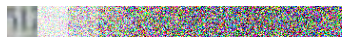

In [14]:
def visualize_diffusion():
  train_dataloader, _ = get_dataloaders(data_root=data_root, batch_size=train_batch_size)
  imgs,_ = next(iter(train_dataloader))
  sample = imgs[3].unsqueeze(0)
  noisy_images = [sample] + [q_sample(sample, torch.tensor([100 * t + 99])) for t in range(10)]
  noisy_images = (torch.cat(noisy_images, dim=0) + 1.) * 0.5
  show_image(noisy_images.clamp(0., 1.), nrow=11)

if __name__ == '__main__':
  visualize_diffusion()

# Backward Learned Diffusion Process

Now suppose you have access to the model $\epsilon_\theta$ in the above description of diffusion models. We know that given a noisy sample $x_t$, one can obtain a slightly denoised version of this sample through the distribution $p_\theta(x_{t-1} | x_t)$, which in our setup is now defined as

\begin{align*}
p_\theta(x_{t-1} | x_t) = \mathcal{N}(\frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right), \tilde{\beta}_t I)
\end{align*}

Below, the task is to complete the function p_sample that takes as input the denoising model $\epsilon_\theta$, a batched noisy image $x$, a batched time-step $t$ and a scalar $t\_index$, and it has to return a sample from $p(x_{t-1} | x_t)$. In the case that $t=1$ (or in code, $t=0$), please just return the mode instead of a sample. For doing this if-condition, you can use $t\_index$ which is just a scalar instead of its batched variant $t$.

Note that all the coefficients $\bar{\alpha}_t$, etc. are already computed above for all $t$, so use the extract function provided to obtain them at different corresponding timesteps.

In [16]:
def p_sample(model, x, t, t_index):
  # Given the denoising model, batched input x, and time-step t, returns a slightly denoised sample at time-step t-1
  # Inputs:
  #   model: The denoising (parameterized noise) model
  #   x: Batched noisy input at time t; size (batch_size, 3, 32, 32)
  #   t: Batched time steps; size (batch_size,)
  #   t_index: Single time-step, whose batched version is present in t
  # Returns:
  #   sample: A sample from the distribution p_\theta(x_{t-1} | x_t); mode if t=0
  with torch.no_grad():
    betas_t = extract(betas, t, x.shape)                           # WRITE CODE HERE: Similar to q_sample, extract betas for specific t's
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)    # WRITE CODE HERE: Same as above, but for sqrt_one_minus_alphas_cumprod
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)               # WRITE CODE HERE: Same as above, but for sqrt_recip_alphas
    
    epsilon = model(x, t)
    p_mean = sqrt_recip_alphas_t * (x - betas_t/sqrt_one_minus_alphas_cumprod_t*epsilon)                        # WRITE CODE HERE: Obtain the mean of the distribution p_\theta(x_{t-1} | x_t)

    if t_index == 0:
      sample = p_mean                       # WRITE CODE HERE: Set the sample as the mode
    else:
      posterior_variance_t = extract(posterior_variance, t, x.shape)         # WRITE CODE HERE: Same as betas_t, but for posterior_variance
      # WRITE CODE HERE
      # Generate a sample from p_\theta(x_{t-1} | x_t) by generating some noise
      noise = torch.randn_like(x)
      
      # Followed by reparameterization to obtain distribution from the mean and variance computed above.
      sample = p_mean + posterior_variance * noise
    return sample

def p_sample_loop(model, shape, timesteps):
  # Given the model, and the shape of the image, returns a sample from the data distribution by running through the backward diffusion process.
  # Inputs:
  #   model: The denoising model
  #   shape: Shape of the samples; set as (batch_size, 3, 32, 32)
  # Returns:
  #   imgs: Samples obtained, as well as intermediate denoising steps, of shape (T, batch_size, 3, 32, 32)
  with torch.no_grad():
    b = shape[0]
    # Start from Pure Noise (x_T)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='Sampling', total=T, leave=False):
        batched_i = torch.full((b,), i, device = device, dtype = torch.long)
        img = p_sample(model, img, batched_i, i) # WRITE CODE HERE: Use the p_sample function to denoise from timestep t to timestep t-1
        imgs.append(img.cpu())

    return torch.stack(imgs)

def sample(model, image_size, batch_size=16, channels=3):
  # Returns a sample by running the sampling loop
  with torch.no_grad():
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), timesteps=T)

# Define the Loss

Now that we have both the forward and the backward diffusion process ready, we need a training criterion. In the introduction, we already saw that the optimization objective for training is to minimize:

\begin{align*}
\mathbb{E}_{t\sim \mathcal{U}(1,T), x_0, \epsilon_t} \left[|| \epsilon_t - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t, t) ||^2\right]
\end{align*}

This boils down to

- Generating some gaussian noise from $\mathcal{N}(0, I)$.
- Getting the noisy images at time $t$ in a batched, one-shot fashion.
- Getting the estimate of noise from the noisy images.
- Computing the loss between the estimate of noise and the actual noise.

In practice here, we will use the **huber** loss instead of the squared loss; so please implement that. Feel free to use PyTorch's criterion to get the huber loss formulation.

In [17]:
def p_losses(denoise_model, x_start, t):
  # Returns the loss for training of the denoise model
  # Inputs:
  #   denoise_model: The parameterized model
  #   x_start: The original images; size (batch_size, 3, 32, 32)
  #   t: Timesteps (can be different at different indices); size (batch_size,)
  # Returns:
  #   loss: Loss for training the model
  noise = torch.randn_like(x_start)

  x_noisy = q_sample(x_start, t, noise)         # WRITE CODE HERE: Obtain the noisy image from the original images x_start, at times t, using the noise noise.
  predicted_noise = denoise_model(x_noisy, t) # WRITE CODE HERE: Obtain the prediction of the noise using the model.

  loss = F.huber_loss(predicted_noise, noise)           # WRITE CODE HERE: Compute the huber loss between true noise generated above, and the noise estimate obtained through the model.

  return loss

### Random sampling of time-step

Finally, randomly sample time-steps from a uniform distribution over timesteps, and return a tensor of size (batch\_size,)

In [18]:
def t_sample(timesteps, batch_size):
  # Returns randomly sampled timesteps
  # Inputs:
  #   timesteps: The max number of timesteps; T
  #   batch_size: batch_size used in training
  # Returns:
  #   ts: Tensor of size (batch_size,) containing timesteps randomly sampled from 0 to timesteps-1 

  ts = torch.randint(low=0, high=timesteps, size=(batch_size,))   # WRITE CODE HERE: Randommly sample a tensor of size (batch_size,) where entries are independently sampled from [0, ..., timesteps-1] 
  return ts

Having defined all the ingredients for **training** and **sampling** from this model, we now define the model itself and the optimizer used for training.

In [19]:
if __name__ == '__main__':
  model = Unet(
    dim=image_size,
    channels=input_channels,
    dim_mults=(1, 2, 4, 8)
  )

  model.to(device)

  optimizer = Adam(model.parameters(), lr=lr)

Finally, let's start training!
Visualization of the samples generated, the original dataset and the reconstructions are saved locally in the notebook! Your task is to just provide sampling of time-steps t, which should be a tensor of size (batch\_size,) sampled uniformly from $[0, T-1]$.

In [20]:
epochs = 30

if __name__ == '__main__':
  train_dataloader, _ = get_dataloaders(data_root, batch_size=train_batch_size)
  for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")

        optimizer.zero_grad()
        imgs,_ = batch
        batch_size = imgs.shape[0]
        x = imgs.to(device)

        t = t_sample(T, batch_size) # Randomly sample timesteps uniformly from [0, T-1]

        loss = p_losses(model, x, t)

        loss.backward()
        optimizer.step()
        
        tepoch.set_postfix(loss=loss.item())

    # Sample and Save Generated Images
    save_image((x + 1.) * 0.5, './results/orig.png')
    samples = sample(model, image_size=image_size, batch_size=64, channels=input_channels)
    samples = (torch.Tensor(samples[-1]) + 1.) * 0.5
    save_image(samples, f'./results/samples_{epoch}.png')
  
  show_image(samples)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


  0%|          | 0/1144 [00:00<?, ?batch/s]

KeyboardInterrupt: 